1. SE CARGAN LAS LIBRERIAS NECESARIAS PARA EL PROCESO

La siguiente celda permite clonar un repositorio de GitHub, navegar al directorio clonado y luego instalar el paquete (keras-vis) en modo editable con dependencias de desarrollo y TensorFlow.

tf-keras-vis es una herramientas que permite visualizar internamente como se están comportando las redes neuronales convolucionales al realizar una determinada tarea sobre un cierto conjunto de datos. Este paquete será útil para más adelante usar el método gradcam++ sobre la dataset fashion m-nist

In [2]:
# Clone the repository
!git clone https://github.com/keisen/tf-keras-vis.git
# Navigate to the cloned directory
%cd tf-keras-vis
# Install the package in editable mode with development dependencies and TensorFlow
!pip install -e .[develop] tensorflow

Cloning into 'tf-keras-vis'...
remote: Enumerating objects: 2335, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 2335 (delta 355), reused 553 (delta 346), pack-reused 1729
Receiving objects: 100% (2335/2335), 91.77 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (1370/1370), done.
/content/tf-keras-vis
Obtaining file:///content/tf-keras-vis
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 438.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [3]:
#estas dos líneas permiten importar automáticamente los cambios que se hagan en modúlos externos de python
%reload_ext autoreload
%autoreload 2

#En este ejercicio básicamente esta libreria se utilizará para definir arreglos
import numpy as np
#En este ejercicio estas dos librerias se importan para realizar gráficos en el entorno de colab
from matplotlib import pyplot as plt
%matplotlib inline

#Las siguientes librerias permiten en resumen crear y entrenar modelos de redes neuronales
import tensorflow as tf
from tensorflow.keras import layers, losses, Model #se importan argumentos útiles para definir los modelos
from tensorflow.keras.datasets import fashion_mnist #importa la base de datos sobre la cual se va a hacer el análisis
from sklearn.metrics import mean_squared_error #función de perdida entre datos originales y clasificados y/o reconstruidos
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Conv2D, MaxPooling2D #se importan capas para construir el modelo

#Esta libreria permite realizar un preprocesamiento a los datos, como por ejemplo, normalización, conversión de espacio de color, etc
from tensorflow.keras.applications.vgg16 import preprocess_input
#Esta libreria se utiliza para convertir la activación a la salida de una neurona en lineal
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
#Esta libreria permite asignar puntajes a las clases de la base de datos para luego ser utilizados en técnicas de visualización
from tf_keras_vis.utils.scores import CategoricalScore

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus #importa el método de visualización gradcamplusplus
from matplotlib import cm #es una libreria para los graficos, genera mapas de colores

#Esta libreria permite saber cuántas gpu se detectaron en el sistema
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


In [4]:
#Esta función se usará más adelante para graficar datos reales vs reconstruidos
def plot_mnist_autoencoder(x,xpred,cmap='gray',vmin=0,vmax=1):
  fig,ax = plt.subplots(2,x.shape[0],figsize=(8,1))
  for i,class_ in enumerate(range(x.shape[0])): #el ciclo se hace dependiendo de las imágenes que se quiere graficar
        ax[0,i].imshow(x[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([]) #esta primera parte grafica datos reales

        ax[1,i].imshow(xpred[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([]) #esta segunda parte grafica datos predichos
  plt.show()
  return

2. CARGAR LOS DATOS QUE VAN A USARSE

En la primera celda se carga la base de datos fashion mnist que dispone de imágenes de prendas, dichas imágenes están en escala de grises y tienen un tamaño de 28x28 píxeles. Hay 10 clases diferentes

En la segunda celda se seleccionan tres clases (bota, camisa, vestido) para visualizar el comportamiento de clasificación sobre ellas con gradcam++ más adelante.

In [5]:
# Cargar y preparar la base de datos
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
x_train = X_train.astype('float32') / 255
x_test = X_test.astype('float32') / 255

# Crea conjuntos de entrenamiento, test y validación para las pruebas que se harán más adelante
x_val = x_train[50000:]
y_val = y_train[50000:]

x_train = x_train[:50000]
y_train = y_train[:50000]

x_train = x_train[..., tf.newaxis]
x_val = x_val[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_test=y_test[:50000]

4422102/4422102 [==============================] - 0s 0us/step


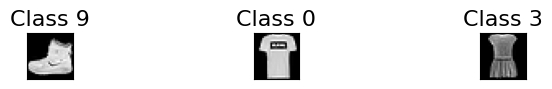

In [6]:
#datos que se van a visualizar con cam grad ++

# Titulos de las imágenes
image_titles = ['Class '+str(y_train[0]), 'Class '+str(y_train[1]), 'Class '+str(y_train[3])]

# Seleccionar las imágenes
img1 = X_train[0]
img2=X_train[1]
img3=X_train[3]
images = np.array([img1, img2, img3])

# Preprocesamiento de los datos
X = preprocess_input(images)

# Gráfica de las imágenes seleccionadas
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,1))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

3. SE DEFINE EL ENCODER, DECODER Y CLASIFICADOR PARA LA BASE DE DATOS

El encoder permite convertir la imagen a un espacio de representación menor y su salida pasa al decoder para que este reconstruya las imágenes a su espacio original.

Luego se define un clasificador que permite etiquetar entre las 10 diferentes clases de las imágenes.

Se junta en un solo modelo los tres anteriores de manera que dicho modelo permite reconstruir y clasificar.

En todos los casos se utilizan capas convolucionales que funcionan como filtros de tamaño 3x3. Las funciones de activación en capas intermedias son establecidas en relu y a la salida en softmax. Se diseña el modelo para que este sea funcional y pueda usarse más adelante en la visualización con gradcam++

Epoch 1/10
782/782 [==============================] - 200s 253ms/step - loss: 0.2538 - reshape_loss: 0.0194 - dense_1_loss: 0.4881 - val_loss: 0.1786 - val_reshape_loss: 0.0115 - val_dense_1_loss: 0.3458
Epoch 2/10
782/782 [==============================] - 201s 257ms/step - loss: 0.1594 - reshape_loss: 0.0102 - dense_1_loss: 0.3087 - val_loss: 0.1535 - val_reshape_loss: 0.0094 - val_dense_1_loss: 0.2975
Epoch 3/10
782/782 [==============================] - 199s 255ms/step - loss: 0.1352 - reshape_loss: 0.0087 - dense_1_loss: 0.2616 - val_loss: 0.1370 - val_reshape_loss: 0.0084 - val_dense_1_loss: 0.2657
Epoch 4/10
782/782 [==============================] - 209s 267ms/step - loss: 0.1215 - reshape_loss: 0.0077 - dense_1_loss: 0.2354 - val_loss: 0.1296 - val_reshape_loss: 0.0079 - val_dense_1_loss: 0.2512
Epoch 5/10
782/782 [==============================] - 206s 263ms/step - loss: 0.1098 - reshape_loss: 0.0072 - dense_1_loss: 0.2125 - val_loss: 0.1313 - val_reshape_loss: 0.0077 - val_d

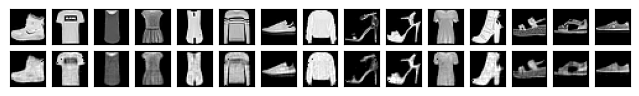

In [7]:
# Definir las entradas
inputs = Input(shape=(28, 28,1))
num_classes=10

# Definir el encoder: la arquitectura se estableció empiricamente
encoder_conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs) #el termino same mantiene el tamaño de la entrada
encoder_pool1 = MaxPooling2D((2, 2), padding='same')(encoder_conv1) #reducir el tamaño de los filtros
encoder_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_pool1)
encoder_pool2 = MaxPooling2D((2, 2), padding='same')(encoder_conv2) #la imagen quedaria de tamaño 14x14

# Definir el decoder: la arquitectura se estableció empiricamente
decoder_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_pool2) #recibe la salida del encoder
decoder_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_conv1)
decoder_flatten = Flatten()(decoder_conv2)
decoder_dense = Dense(28*28, activation="relu")(decoder_flatten)
reconstructed_outputs = Reshape([28, 28])(decoder_dense) #imagen original (28x28)

#Definir el clasificador: la arquitectura se estableció empiricamente
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_pool2) #recibe la salida del encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x=Flatten()(x)
classification_outputs = layers.Dense(num_classes, activation='softmax')(x) #porporciona un vector con las probabilidades de pertencencia a cada clase


# Crear el modelo del autoencoder
autoencoder = Model(inputs, reconstructed_outputs)

# Crear el modelo del clasificador
classifier = Model(inputs, classification_outputs)

# Combinar los modelos de autoencoder y clasificador
combined_outputs = [reconstructed_outputs, classification_outputs]
combined_model = Model(inputs, combined_outputs) #este modelo reconstruye y clasifica

# Compilar el modelo combinado
combined_model.compile(optimizer='adam',
                                     loss=['mse', 'sparse_categorical_crossentropy'],
                                     loss_weights=[0.5, 0.5]  # Los pesos se distribuyen de igual a igual para clasificación y reconstrucción
                                     )

# Entrenar el modelo
combined_model.fit(x_train, [x_train, y_train], epochs=10, batch_size=64, validation_data=(x_val, [x_val, y_val]))

#Reconstrucción y clasificación
prediction=combined_model.predict(x_train) #ofrece dos tuplas (una para reconstrucción y otra para clasificación)
predicted_classes = tf.argmax(prediction[1], axis=1).numpy() #se selecciona la probabilidad más alta dada por la clasificación (asignación de clases)

#error cuadrático medio entre la clasificación y datos originales
mse = mean_squared_error(y_train, predicted_classes)
rmse = np.sqrt(mse)
print(rmse)

#Graficar reconstrucciones vs datos originales
plot_mnist_autoencoder(x_train[:15],prediction[0][:15])

Con respecto a la clasificación se puede observar que al realizar el entrenamiento, la perdida va disminuyendo conforme las épocas aumentan pero al realizar la medida de MSE sobre el conjunto total de datos este tiene un valor alto. Como conclusión habría un sobreentrenamiento que deberia mejorarse modificando parámetros del modelo.

Con respecto a la reconstrucción, la imagen muestra que al parecer esta se hace de mejor manera que la clasificación pese a que se les dio prioridad del 50/50. El problema seguramente se debe a que la estructura de las redes es más compleja para los encoders y decoders

4. VISUALIZACIÓN CAPAS GRADCAM++


radient-weighted Class Activation Mapping++ es una versión mejorada de grad cam que permite visualizar que zonas de una imagen son importantes para la predicción de una determinada clase. Lo anterior puede ayudar a mejorar el modelo para que este converja más rápido


In [8]:
#Lo primero que se hace es ver como esta compuesto el modelo para tomar el nombre de las capas.
classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          3692

In [9]:
#esta función permite reemplazar a lineal la salida de una determinada neurona, esto se hace porque
#funciones como softmax o relu podrían obstruir la generación de los mapas de atención
replace2linear = ReplaceToLinear()

# Como se dijo anteriormente esto permite asignar puntajes a las 3 clases con las cuales se va a trabajar y dichos puntajes
#luego permiten realizar la visualización.
#score = CategoricalScore(1)

In [11]:
#La siguiente función permite  aplicar el método gradcam++, se necesita ingresarle el modelo:
#el modelo, los datos a visualizar (3 imágenes para este ejercicio), los titulos de la
#imagen para la grafica y el nombre de la capa a visualizar
def generate_and_visualize_gradcam(classifier, X,  image_titles,name_layer):
    # Crea GradCAM++ object
    gradcam = GradcamPlusPlus(classifier,#modelo del clasificador
                              model_modifier=replace2linear, #reemplaza salidas no lineales por lineales para que sean más compatibles con el modelo
                              clone=True)#se clona el modelo original para evitar modificaciones permanentes sobre este

    # Expandir dimensiones si es necesario, esto se hace para que las imágenes sean compatibles con el clasificador
    if X.ndim == 3:
        X = np.expand_dims(X, axis=-1)

    # Genera mapa de calor, aquí se especifica el nombre de la capa a visualizar
    for j in range(10):
          score = CategoricalScore(j)
          cam = gradcam(score, X, normalize_cam = False,penultimate_layer=name_layer)
          print("Gráficos de activación para clase "+str(j))
          # Gráfica de resultados
          f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
          for i, title in enumerate(image_titles):
              heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
              ax[i].set_title(title, fontsize=16)
              ax[i].imshow(images[i])
              ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
              ax[i].axis('off')
          plt.tight_layout()
          plt.show()

    return cam


Gráficos de activación para clase 0


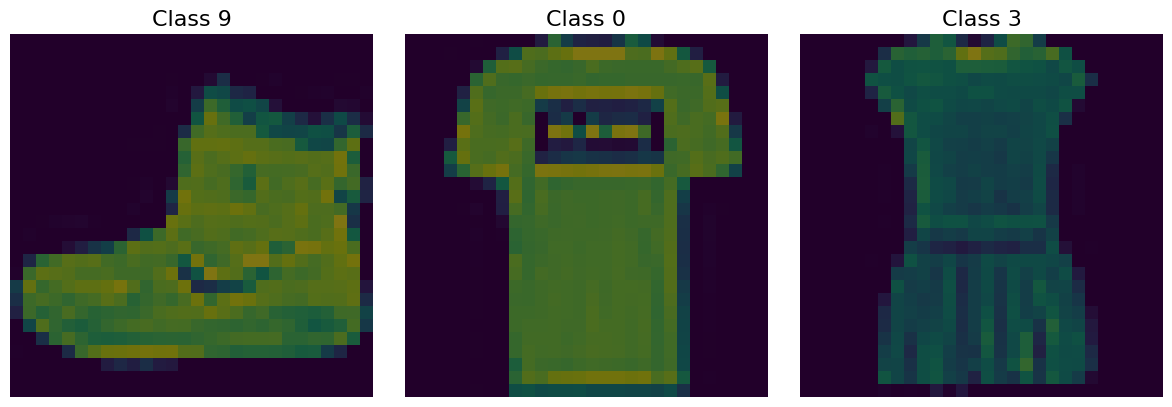

Gráficos de activación para clase 1


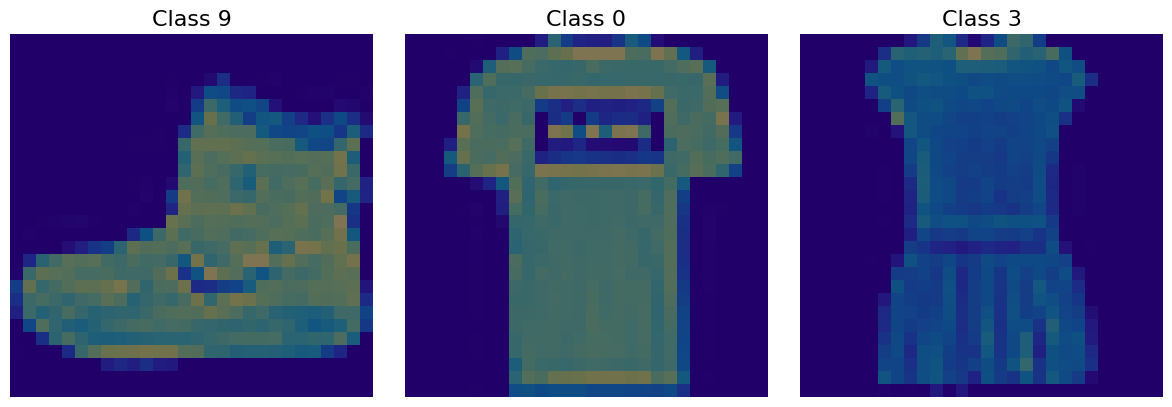

Gráficos de activación para clase 2


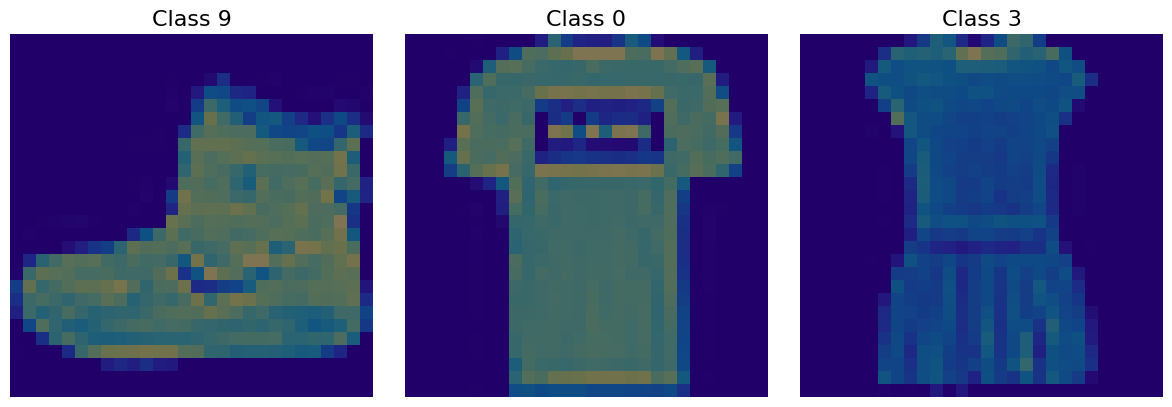

Gráficos de activación para clase 3


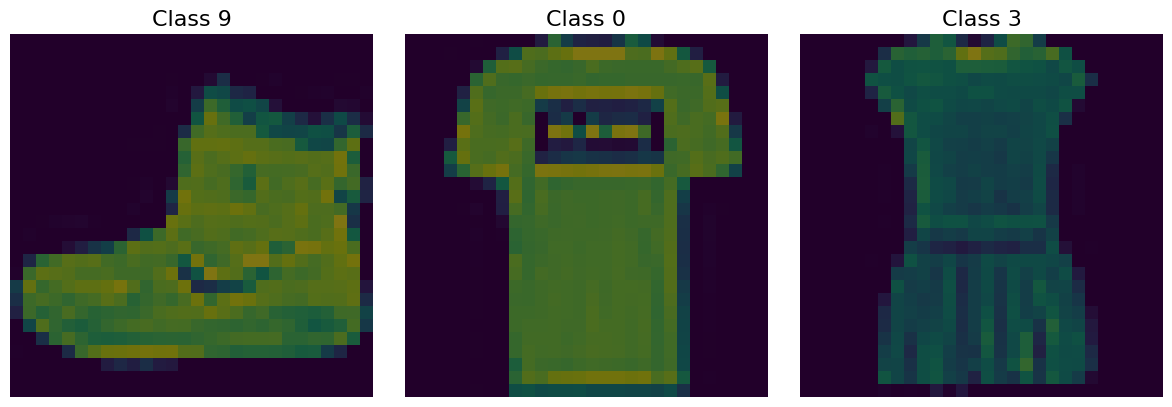

Gráficos de activación para clase 4


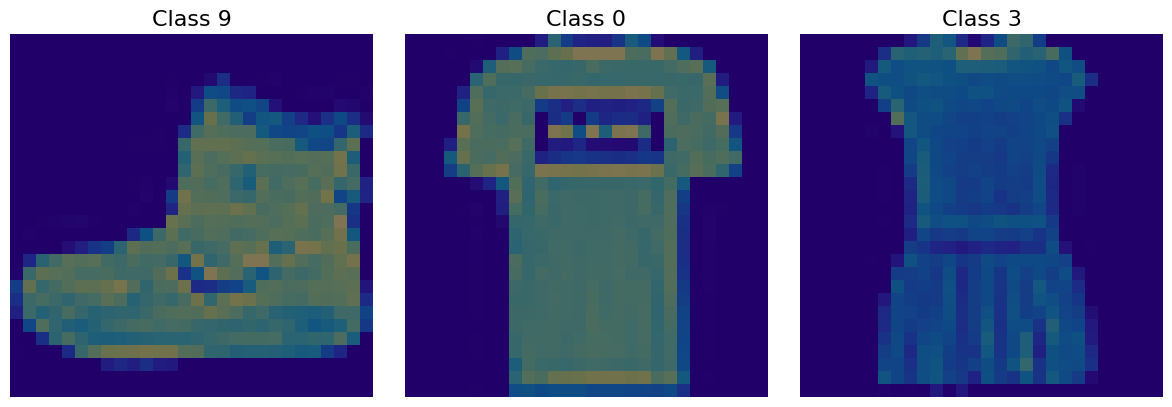

Gráficos de activación para clase 5


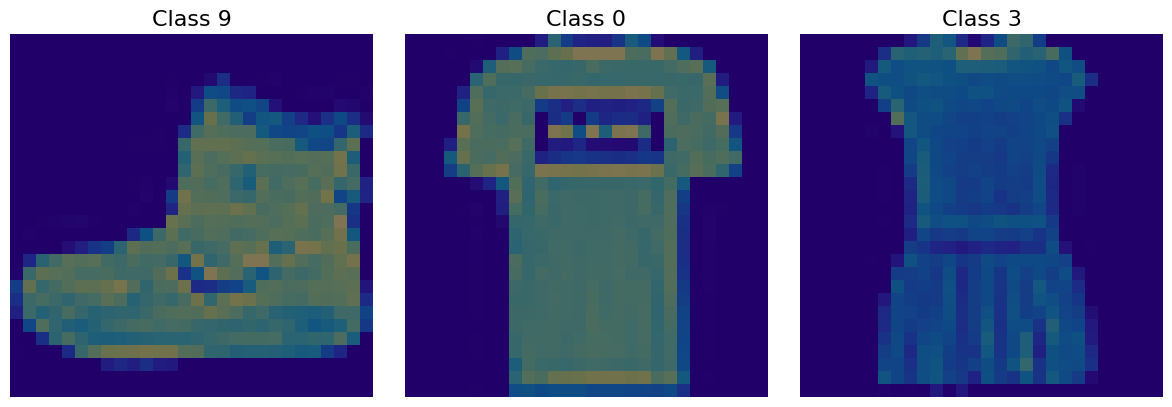

Gráficos de activación para clase 6


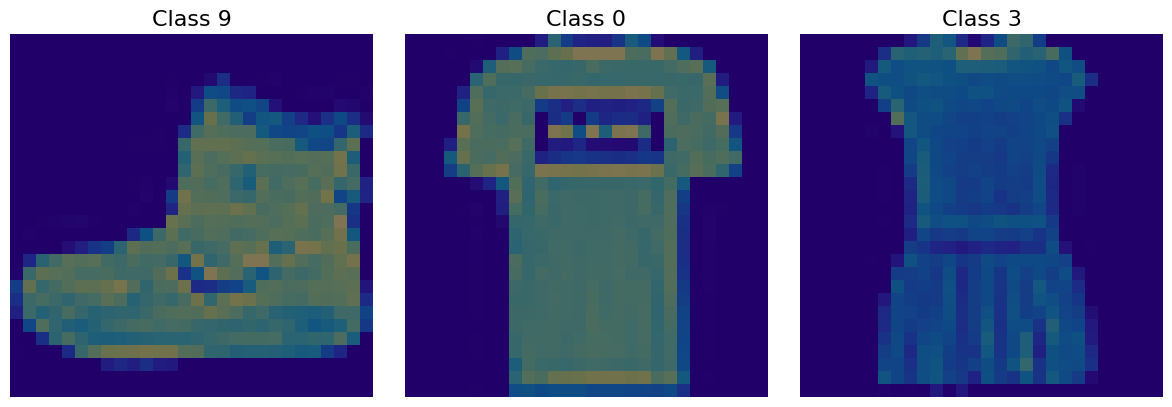

Gráficos de activación para clase 7


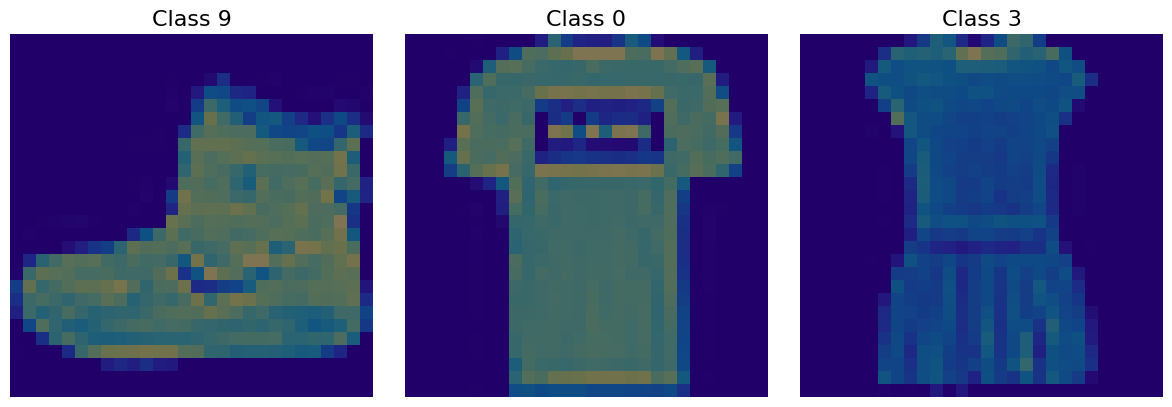

Gráficos de activación para clase 8


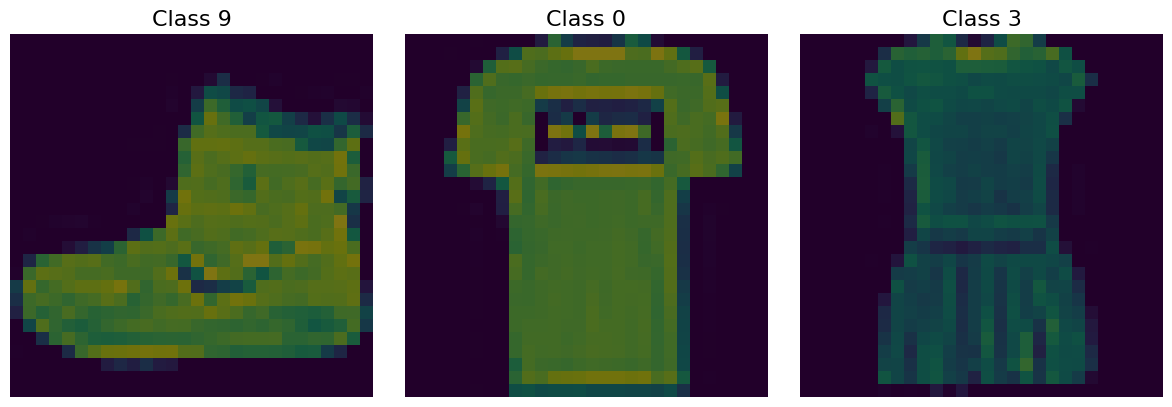

Gráficos de activación para clase 9


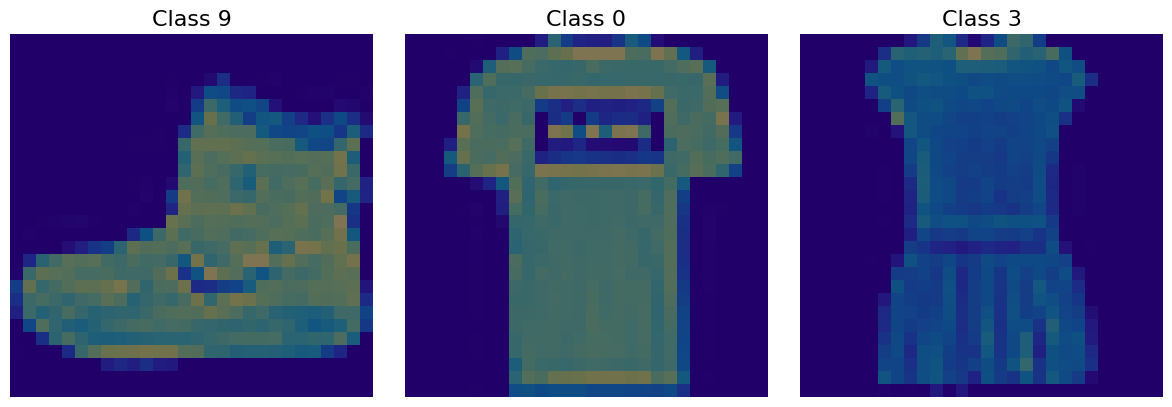

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [12]:
# Prueba sobre la capa encoderconv1 que recibe la entrada
generate_and_visualize_gradcam(classifier, X, image_titles,'conv2d_4')


De los resultados obtenidos se puede observar que en la primera y segunda imagen se resaltan más los bordes de las mismas. Y es que los bordes permiten determinar la forma de las clases para esta base de datos en particular. Por otro lado en la tercera imagen no se resaltan tantas zonas e intuyo a que esto se debe a que la imagen es más dificil de clasificar por su forma.

A partir de la visualización podria concluir que para mejorar la clasificación se debe disminuir el tamaño de los filtros de las capas convolucionales para que capturen más detalles especialmente en los bordes. Así mismo la modificación permitiría determinar la forma de la tercera imagen pero adicional creo que a esta debería aplicarse otro tipo de preproceso para enfocar la forma de la imagen

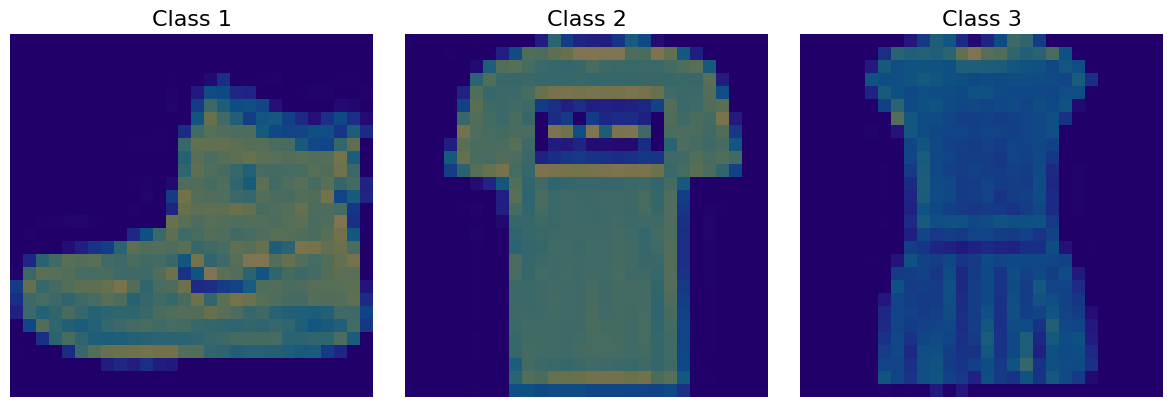

In [ ]:
#prueba sobre la capa convolucional después de la capa de la primera prueba
generate_and_visualize_gradcam(classifier, X, score, image_titles,'max_pooling2d_4')

En esta segunda prueba se grafica la salida de la capa de pooling que se aplica a la capa de la primera prueba. Se resalta que en la imagen del vestido se visualizan más detalles que en la primera prueba. Seguramente, esto se debe a que maxpooling conserva solo los detalles más importantes de cada ventana de la imagen.

Igualmente se observa que en la primera y la segunda imagen visualmente se resaltan más los detalles de los bordes. Seguramente aumentando el tamaño de la ventana de pooling permitirá elminar detalles redundantes y conservar la información relevante para la clasificación.

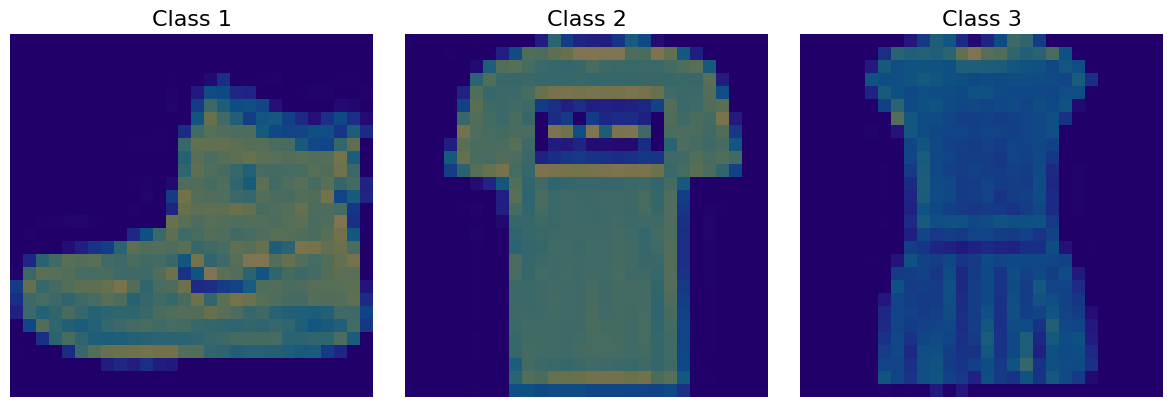

In [ ]:
#prueba sobre la última capa convolucional
generate_and_visualize_gradcam(classifier, X, score, image_titles,'conv2d_17')

En esta tercera prueba se esta graficando la última capa convolucional antes de realizar el aplanamiento y posterior clasificación con la capa densa. Se observa que visualmente los datos no mejoran notoriamente con respecto a la prueba 2. Esto se debe seguramente a que en el clasificador no se tiene una estructura compleja, para que la visualización mejore habría que agregar más capas convolucionales al modelo para que capture más detalles

PRUEBAS ADICIONALES

En la primera celda se gráfica 200 datos en un espacio de dos dimensiones y se puede observar la formación de algunos grupos.

En la segunda celda se realiza una gráfica similar a la primera pero con los datos representados como puntos sobre el espacio.

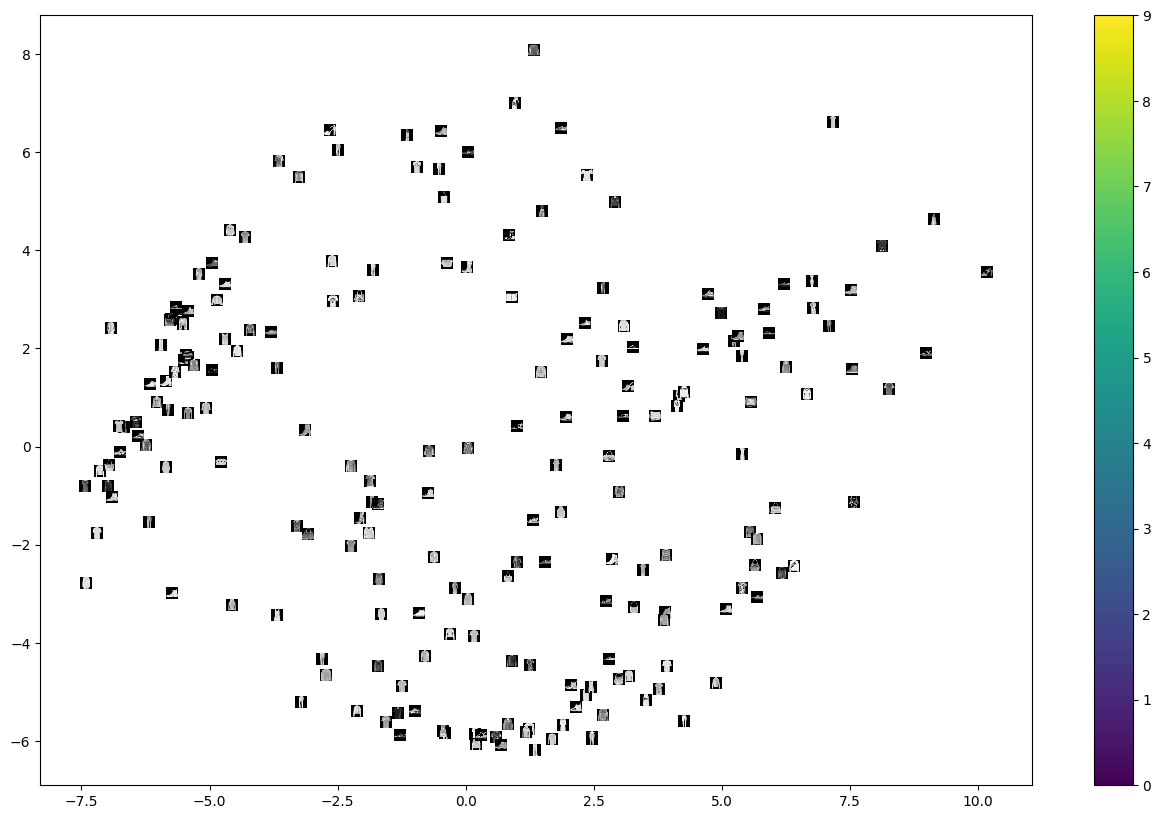

In [ ]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

#La función recorre cada punto en las características en el espacio latente, extrae la imagen correspondiente de images,
#crea una representación de la imagen incrustada (utilizando OffsetImage), y la agrega al gráfico junto con las coordenadas en Z.
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

N=200
#reducción de dimensiones con PCA
red = PCA(n_components=2, random_state=123)
Z = red.fit_transform(x_train.reshape(x_train.shape[0],-1))

#Grafica de los datos
plot_mnist_2d(Z[:N],y_val[:N],x_val[:N],img_w=28,img_h=28,zoom=0.3,cmap='gray')
plt.scatter(Z[:N,0],Z[:N,1],c=y_val[:N])
plt.colorbar()
plt.show()


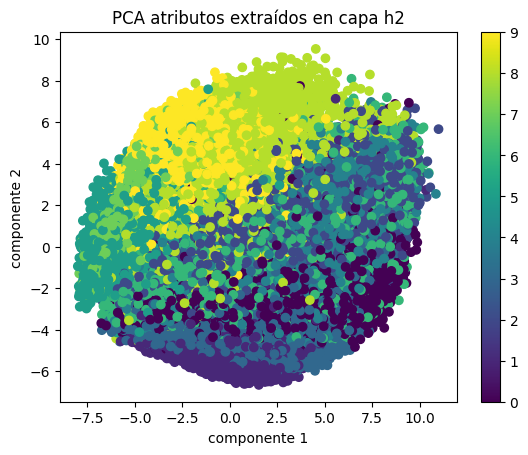

In [ ]:
plt.scatter(Z[:,0],Z[:,1],c=y_train)
plt.colorbar()
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')
plt.show()

En esta imagen se puede observar la formación de diferentes grupos, algunos predominantes sobre otros. Por ejemplo el grupo verde no tiene una clasificación clara, tiende a confundirse con elementos de otros grupos